In [1]:
import torch
from torch import nn
from torchinfo import summary

from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

import pytorch_lightning as pl
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from tqdm.auto import tqdm
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import numpy  as np
import tracemalloc 

import json
import os
import glob
import pickle
from itertools import combinations
import gc
import time
import random

import warnings
warnings.filterwarnings("ignore")

/home/tran/miniconda3/envs/compgan/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [31]:
TEST = False

In [3]:
DATA_ROOT = "../data/compgan_dataset/"

train_data_file_name_ = "train_data{}.npy"
train_label_file_name_ = "train_label{}.npy"
test_data_file_name_ = "test_data{}.npy"
test_label_file_name_ = "test_label{}.npy"

TRAIN_FOLDER_PATH = os.path.join(DATA_ROOT, "train")
TEST_FOLDER_PATH = os.path.join(DATA_ROOT, "test")
RESULT_FOLDER_PATH = os.path.join(DATA_ROOT, "results")
PREV_CHECKPOINT_FOLDER_PATH = os.path.join(DATA_ROOT, "prev_checkpoint")

assert os.path.isdir(TRAIN_FOLDER_PATH) and os.path.isdir(TEST_FOLDER_PATH)
os.makedirs(RESULT_FOLDER_PATH, exist_ok=True)

data_files = sorted(glob.glob(os.path.join(TRAIN_FOLDER_PATH, train_data_file_name_.format("*"))))
print(data_files)
print(len(data_files))

['../data/compgan_dataset/train/train_data0.npy', '../data/compgan_dataset/train/train_data1.npy', '../data/compgan_dataset/train/train_data10.npy', '../data/compgan_dataset/train/train_data11.npy', '../data/compgan_dataset/train/train_data12.npy', '../data/compgan_dataset/train/train_data13.npy', '../data/compgan_dataset/train/train_data14.npy', '../data/compgan_dataset/train/train_data15.npy', '../data/compgan_dataset/train/train_data2.npy', '../data/compgan_dataset/train/train_data3.npy', '../data/compgan_dataset/train/train_data4.npy', '../data/compgan_dataset/train/train_data5.npy', '../data/compgan_dataset/train/train_data6.npy', '../data/compgan_dataset/train/train_data7.npy', '../data/compgan_dataset/train/train_data8.npy', '../data/compgan_dataset/train/train_data9.npy']
16


In [4]:
USER_NUM = 16
SENSOR_NUM = 7
EACH_SENSOR_CHANNEL = 6
assert USER_NUM == len(data_files)
feature_num = SENSOR_NUM * EACH_SENSOR_CHANNEL

In [5]:
# important

label_list = ['歩行(平地)',
 '歩行(階段)',
 'ベッド上での起き上がり',
 'ベッド椅子間の乗り移り(立つ)',
 'ベッド椅子間の乗り移り(立たない)',
 '立ち座り',
 '座位保持・座位バランス',
 '立位保持・立位バランス',
 '関節可動域増大訓練(肩)',
 '関節可動域増大訓練(股関節)']

label_dict = dict(enumerate(label_list))

In [6]:
# important
eng_label_dict = dict(zip(
    label_list,
    ['Walking', 'Upstair', 'Bed_Standup', 'Change_Bed', 'Change_Bed_Standup', 'Sit_Down', 'Sit', 'Stand', 'Shoulder_Exercise', 'Hip_Exercise']
))

eng_label_list = [eng_label_dict[i] for i in label_list]

In [7]:
# Update after 2023/11/11 houkoku
class CustomTrainDataset(Dataset):
    TRAIN_MODE = "train"
    TEST_MODE = "test"
    
    def __init__(self, mode, feature_data, label_data, missing_sensor_numbers=0):
        self.mode = mode
        assert mode in [self.TRAIN_MODE, self.TEST_MODE]
        
        self.features = feature_data
        self.label = label_data
        assert len(self.features) == len(self.label), "features len is not equal to label len"
        self.missing_sensor_numbers = missing_sensor_numbers

        self.missing_index_list = []
        for missing_count in range(missing_sensor_numbers + 1):
            for missing_index in combinations(range(SENSOR_NUM), missing_count):
                self.missing_index_list.append(missing_index)

    def transform(self, one_feature, missing_sensor_id_list):
        # Make one sensor data become 0
        one_feature_cp = one_feature.copy()
        
        for missing_sensor_id in missing_sensor_id_list:
            one_feature_cp[:, missing_sensor_id*6:(missing_sensor_id+1)*6] = 0
        return one_feature_cp
        
    def __len__(self):

        # take all available missing pattern * data number
        return len(self.features) * len(self.missing_index_list)
    
    def __getitem__(self, idx):
        # take all available missing pattern
        missing_sensor_id_list = self.missing_index_list[ idx // len(self.features) ]
        x = self.transform(self.features[ idx % len(self.features) ], missing_sensor_id_list)
        label = self.label[idx % len(self.features)]
        return x, int(label)


In [8]:
class DataModule(pl.LightningDataModule):
    STANDARDIZE = False
    BATCH_SIZE = 4096
    
    def __init__(self, test_user, missing_sensor_numbers):
        super().__init__()
        self.test_user = test_user
        self.missing_sensor_numbers = missing_sensor_numbers

    def load_data(self, mode):
        if mode == "train":
            folder_path = TRAIN_FOLDER_PATH
            data_file_name = train_data_file_name_
            label_file_name = train_label_file_name_

            train_data_file_name = data_file_name.format(self.test_user)
            train_label_file_name = label_file_name.format(self.test_user)
    
            train_data_file_path = os.path.join(folder_path, train_data_file_name)
            train_label_file_path = os.path.join(folder_path, train_label_file_name)
            train_val_data, train_val_label = np.load(train_data_file_path), np.load(train_label_file_path)
            l, s, d, w = train_val_data.shape
            train_val_data = train_val_data.reshape(l, s * d, w).transpose(0,2,1)
            
        elif mode == "test":
            folder_path = TEST_FOLDER_PATH
            data_file_name = test_data_file_name_
            label_file_name = test_label_file_name_
    
            train_data_file_name = data_file_name.format(self.test_user)
            train_label_file_name = label_file_name.format(self.test_user)
    
            train_data_file_path = os.path.join(folder_path, train_data_file_name)
            train_label_file_path = os.path.join(folder_path, train_label_file_name)
            train_val_data, train_val_label = np.load(train_data_file_path), np.load(train_label_file_path)
            l, s, d, w = train_val_data.shape
            train_val_data = train_val_data.reshape(l, s * d, w).transpose(0,2,1)
    
        return train_val_data, train_val_label

    def setup(self, stage: str):
        # Assign Train/val split(s) for use in Dataloaders
        
        if stage == "validate" or stage == "fit":
            train_val_data, train_val_label = self.load_data("train")
            self.train_data, self.val_data, self.train_label, self.val_label = train_test_split(
                train_val_data, train_val_label, test_size=0.2, train_size=0.8, random_state=42, shuffle=True)

            self.train_dataset = CustomTrainDataset(
                CustomTrainDataset.TRAIN_MODE, self.train_data, self.train_label, missing_sensor_numbers=self.missing_sensor_numbers)
            self.val_dataset = CustomTrainDataset(
                CustomTrainDataset.TEST_MODE, self.val_data, self.val_label, missing_sensor_numbers=self.missing_sensor_numbers)

        elif stage == "test" or stage == "predict":
            train_val_data, train_val_label = self.load_data("test")
            self.test_data = train_val_data
            self.test_label = train_val_label

            self.test_dataset = CustomTrainDataset(
                CustomTrainDataset.TEST_MODE, self.test_data, self.test_label, missing_sensor_numbers=self.missing_sensor_numbers)
    
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.BATCH_SIZE, num_workers=4, shuffle=True, pin_memory=True)
    
    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.BATCH_SIZE,  num_workers=4, shuffle=False, pin_memory=True)
    
    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.BATCH_SIZE,  num_workers=4, shuffle=False, pin_memory=True)

    def predict_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.BATCH_SIZE,  num_workers=4, shuffle=False, pin_memory=True)

    def teardown(self, stage):
        print("teardown")
        if stage == "validate" or stage == "fit":
            del self.train_data, self.train_label
            del self.val_data, self.val_label
            del self.train_dataset
            del self.val_dataset
            
        elif stage == "test" or stage == "predict":
            del self.test_data, self.test_label
            del self.test_dataset
        gc.collect()


In [12]:
if TEST:
    data_module = DataModule(test_user=0, missing_sensor_numbers=1)
    data_module.setup("fit")
    print(data_module.train_data.shape)
    print(data_module.val_data.shape)
    # print(data_module.test_data.shape)

(5088, 256, 42)
(1273, 256, 42)


In [20]:
if TEST:
    data = data_module.val_dataset[1273 * 2 + 1]
    print(data[1], data[0][0])
    print(len(data_module.val_dataset))

9 [0.43193123 0.36511    0.4571525  0.5014892  0.4986307  0.49944028
 0.         0.         0.         0.         0.         0.
 0.3743741  0.37305066 0.3929023  0.5047875  0.49222404 0.49100468
 0.43410605 0.43467084 0.5160583  0.50026983 0.5007496  0.50066966
 0.44348815 0.43137488 0.33850628 0.50237876 0.49835086 0.5005297
 0.42213604 0.3805614  0.48026636 0.469236   0.4842282  0.50195897
 0.432378   0.4497935  0.51478547 0.50013995 0.49961022 0.50084955]
10184


In [21]:
if TEST:
    del data_module, data
    gc.collect()

## MODEL DEFINITION

In [22]:
class SelfAttention(nn.Module):
    def __init__(self, input_dim):
        super(SelfAttention, self).__init__()
        self.input_dim = input_dim
        self.query = nn.Linear(input_dim, input_dim)
        self.key = nn.Linear(input_dim, input_dim)
        self.value = nn.Linear(input_dim, input_dim)
        self.softmax = nn.Softmax(dim=2)
        
    def forward(self, x):
        queries = self.query(x)
        keys = self.key(x)
        values = self.value(x)
        
        scores = torch.bmm(queries, keys.transpose(1, 2)) / (self.input_dim ** 0.5)
        attention = self.softmax(scores)
        weighted = torch.bmm(attention, values)
        return weighted

In [23]:

class LSTMModel(pl.LightningModule):
    def __init__(self, hidden_size=128, input_size=42, output_size=10, **kwargs):
        super().__init__()
        self.save_hyperparameters()
        self.example_input_array = torch.Tensor(1024, 256, input_size)
        
        self.rnn = nn.LSTM(input_size=input_size, 
                          hidden_size=hidden_size,
                          num_layers=3,
                          batch_first=True)
        
        self.seq_1 = nn.Sequential(
            nn.Linear(in_features=hidden_size, out_features=hidden_size),
            nn.BatchNorm1d(num_features=hidden_size),
            nn.Dropout1d(p=0.2),
            nn.ReLU(),
            nn.Linear(in_features=hidden_size, out_features=hidden_size),
            nn.BatchNorm1d(num_features=hidden_size),
            nn.Dropout1d(p=0.2),
            nn.ReLU(),
        )
        
        self.seq_2 = nn.Sequential(
            nn.Linear(in_features=hidden_size, out_features=hidden_size),
            nn.BatchNorm1d(num_features=hidden_size),
            nn.Dropout1d(p=0.2),
            nn.ReLU(),
            nn.Linear(in_features=hidden_size, out_features=hidden_size),
            nn.BatchNorm1d(num_features=hidden_size),
            nn.Dropout1d(p=0.2),
            nn.ReLU(),
        )
        
        self.classifier = nn.Linear(in_features=3 * hidden_size, out_features=output_size)
        
    def forward(self, x):
        activation, _ = self.rnn(x)
        
        b, _, _ = activation.size()
        lstm_output = activation[:,-1,:].view(b,-1)
        seq_1_output = self.seq_1(lstm_output)
        seq_2_output = self.seq_2(lstm_output)
        
        output = torch.concat([lstm_output, seq_1_output, seq_2_output], dim=1)
        output = self.classifier(output)
        
        return output
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(params=self.parameters(), lr=0.0005)
        return optimizer
    
    def training_step(self, batch, batch_idx):
        X, y = batch
        X = X.float()
        # 1. Forward pass
        y_pred = self.forward(X)
        # 2. Calculate  and accumulate loss
        loss = F.cross_entropy(y_pred, y)
        
        self.log("train_loss", loss)
        
        return loss
    
    def test_step(self, batch, batch_idx):
        # this is the test loop
        X, y = batch
        X = X.float()
    
        # 1. Forward pass
        test_pred_logits = self.forward(X)

        # Calculate and accumulate accuracy
        test_pred_labels = test_pred_logits.argmax(dim=1)
        test_acc = ((test_pred_labels == y).sum().item()/len(test_pred_labels))
        self.log("test_acc", test_acc)

    def validation_step(self, batch, batch_idx):
        # this is the validation loop
        X, y = batch
        X = X.float()
        
        y_pred = self.forward(X)
        # 2. Calculate  and accumulate loss
        loss = F.cross_entropy(y_pred, y)
        
        self.log("val_loss", loss)

    def predict_step(self, batch, batch_idx):
        X, y = batch
        X = X.float()
        
        test_pred_logits = self.forward(X)
        test_pred_labels = test_pred_logits.argmax(dim=1)
        
        return test_pred_labels
        

In [24]:
class LSTMBiModel(pl.LightningModule):
    def __init__(self, hidden_size=128, input_size=42, output_size=10, **kwargs):
        super().__init__()
        self.save_hyperparameters()
        self.example_input_array = torch.Tensor(1024, 256, input_size)
        
        self.rnn = nn.LSTM(input_size=input_size, 
                          hidden_size=hidden_size,
                          num_layers=3,
                          batch_first=True,
                          bidirectional=True)

        double_hidden_size = hidden_size * 2
        
        self.seq_1 = nn.Sequential(
            nn.Linear(in_features=double_hidden_size, out_features=double_hidden_size),
            nn.BatchNorm1d(num_features=double_hidden_size),
            nn.Dropout1d(p=0.2),
            nn.ReLU(),
            nn.Linear(in_features=double_hidden_size, out_features=double_hidden_size),
            nn.BatchNorm1d(num_features=double_hidden_size),
            nn.Dropout1d(p=0.2),
            nn.ReLU(),
        )
        
        self.seq_2 = nn.Sequential(
            nn.Linear(in_features=double_hidden_size, out_features=double_hidden_size),
            nn.BatchNorm1d(num_features=double_hidden_size),
            nn.Dropout1d(p=0.2),
            nn.ReLU(),
            nn.Linear(in_features=double_hidden_size, out_features=double_hidden_size),
            nn.BatchNorm1d(num_features=double_hidden_size),
            nn.Dropout1d(p=0.2),
            nn.ReLU(),
        )
        
        self.classifier = nn.Linear(in_features=3 * double_hidden_size, out_features=output_size)
        
    def forward(self, x):
        activation, (h, _) = self.rnn(x)
        b, _, _ = activation.size()
        
        lstm_output = h[-2:].permute(1,0,2).reshape(b, -1)
        seq_1_output = self.seq_1(lstm_output)
        seq_2_output = self.seq_2(lstm_output)
        
        output = torch.concat([lstm_output, seq_1_output, seq_2_output], dim=1)
        output = self.classifier(output)
        
        return output
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(params=self.parameters(), lr=0.0005)
        return optimizer
    
    def training_step(self, batch, batch_idx):
        X, y = batch
        X = X.float()
        # 1. Forward pass
        y_pred = self.forward(X)
        # 2. Calculate  and accumulate loss
        loss = F.cross_entropy(y_pred, y)
        
        self.log("train_loss", loss)
        
        return loss
    
    def test_step(self, batch, batch_idx):
        # this is the test loop
        X, y = batch
        X = X.float()
    
        # 1. Forward pass
        test_pred_logits = self.forward(X)

        # Calculate and accumulate accuracy
        test_pred_labels = test_pred_logits.argmax(dim=1)
        test_acc = ((test_pred_labels == y).sum().item()/len(test_pred_labels))
        self.log("test_acc", test_acc)

    def validation_step(self, batch, batch_idx):
        # this is the validation loop
        X, y = batch
        X = X.float()
        
        y_pred = self.forward(X)
        # 2. Calculate  and accumulate loss
        loss = F.cross_entropy(y_pred, y)
        
        self.log("val_loss", loss)

    def predict_step(self, batch, batch_idx):
        X, y = batch
        X = X.float()
        
        test_pred_logits = self.forward(X)
        test_pred_labels = test_pred_logits.argmax(dim=1)
        
        return test_pred_labels
        

In [25]:
class LSTMAttentionModel(pl.LightningModule):
    def __init__(self, hidden_size=128, input_size=42, output_size=10, **kwargs):
        super().__init__()
        self.save_hyperparameters()
        self.example_input_array = torch.Tensor(1024, 256, input_size)
        
        self.rnn1 = nn.LSTM(input_size=input_size, 
                          hidden_size=hidden_size,
                          num_layers=1,
                          batch_first=True)
        
        self.attention1 = SelfAttention(
            input_dim=hidden_size)

        self.rnn2 = nn.LSTM(input_size=hidden_size, 
                          hidden_size=hidden_size,
                          num_layers=1,
                          batch_first=True)
        
        self.attention2 = SelfAttention(
            input_dim=hidden_size
        )

        self.rnn3 = nn.LSTM(input_size=hidden_size, 
                  hidden_size=hidden_size,
                  num_layers=1,
                  batch_first=True)
        
        self.seq_1 = nn.Sequential(
            nn.Linear(in_features=hidden_size, out_features=hidden_size),
            nn.BatchNorm1d(num_features=hidden_size),
            nn.Dropout1d(p=0.2),
            nn.ReLU(),
            nn.Linear(in_features=hidden_size, out_features=hidden_size),
            nn.BatchNorm1d(num_features=hidden_size),
            nn.Dropout1d(p=0.2),
            nn.ReLU(),
        )
        
        self.seq_2 = nn.Sequential(
            nn.Linear(in_features=hidden_size, out_features=hidden_size),
            nn.BatchNorm1d(num_features=hidden_size),
            nn.Dropout1d(p=0.2),
            nn.ReLU(),
            nn.Linear(in_features=hidden_size, out_features=hidden_size),
            nn.BatchNorm1d(num_features=hidden_size),
            nn.Dropout1d(p=0.2),
            nn.ReLU(),
        )
        
        self.classifier = nn.Linear(in_features=3 * hidden_size, out_features=output_size)
        
    def forward(self, x):
        activation, _ = self.rnn1(x)
        activation = self.attention1(activation)
        activation, _ = self.rnn2(activation)
        activation = self.attention2(activation)
        activation, (h, _) = self.rnn3(activation)

        b, _, _ = activation.size()
        
        lstm_output = activation[:,-1,:].view(b,-1)
        
        seq_1_output = self.seq_1(lstm_output)
        seq_2_output = self.seq_2(lstm_output)
        
        output = torch.concat([lstm_output, seq_1_output, seq_2_output], dim=1)
        output = self.classifier(output)
        
        return output
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(params=self.parameters(), lr=0.0005)
        return optimizer
    
    def training_step(self, batch, batch_idx):
        X, y = batch
        X = X.float()
        # 1. Forward pass
        y_pred = self.forward(X)
        # 2. Calculate  and accumulate loss
        loss = F.cross_entropy(y_pred, y)
        
        self.log("train_loss", loss, prog_bar=True)
        
        return loss
    
    def test_step(self, batch, batch_idx):
        # this is the test loop
        X, y = batch
        X = X.float()
        y = y
    
        # 1. Forward pass
        test_pred_logits = self.forward(X)

        # Calculate and accumulate accuracy
        test_pred_labels = test_pred_logits.argmax(dim=1)
        test_acc = ((test_pred_labels == y).sum().item()/len(test_pred_labels))
        self.log("test_acc", test_acc)
        
    def validation_step(self, batch, batch_idx):
        # this is the validation loop
        X, y = batch
        X = X.float()
        y = y
        
        y_pred = self.forward(X)
        # 2. Calculate  and accumulate loss
        loss = F.cross_entropy(y_pred, y)
        
        self.log("val_loss", loss, prog_bar=True)

    def predict_step(self, batch, batch_idx):
        X, y = batch
        X = X.float()
        
        test_pred_logits = self.forward(X)
        test_pred_labels = test_pred_logits.argmax(dim=1)
        
        return test_pred_labels
        

In [26]:

class CNNLSTMModel(pl.LightningModule):
    def __init__(self, hidden_size=128, sequence_length=256, input_size=42, cnn_filter_size=64, output_size=10, **kwargs):
        super().__init__()
        self.save_hyperparameters()
        self.example_input_array = torch.Tensor(1024, sequence_length, input_size)
        
        self.cnn = nn.Conv1d(sequence_length, cnn_filter_size, kernel_size=5, padding="same")
        
        self.rnn = nn.LSTM(input_size=input_size, 
                          hidden_size=hidden_size,
                          num_layers=3,
                          batch_first=True)
 
        self.seq_1 = nn.Sequential(
            nn.Linear(in_features=hidden_size, out_features=hidden_size),
            nn.BatchNorm1d(num_features=hidden_size),
            nn.Dropout1d(p=0.2),
            nn.ReLU(),
            nn.Linear(in_features=hidden_size, out_features=hidden_size),
            nn.BatchNorm1d(num_features=hidden_size),
            nn.Dropout1d(p=0.2),
            nn.ReLU(),
        )
        
        self.seq_2 = nn.Sequential(
            nn.Linear(in_features=hidden_size, out_features=hidden_size),
            nn.BatchNorm1d(num_features=hidden_size),
            nn.Dropout1d(p=0.2),
            nn.ReLU(),
            nn.Linear(in_features=hidden_size, out_features=hidden_size),
            nn.BatchNorm1d(num_features=hidden_size),
            nn.Dropout1d(p=0.2),
            nn.ReLU(),
        )
        
        self.classifier = nn.Linear(in_features=3 * hidden_size, out_features=output_size)
        
    def forward(self, x):
        output = self.cnn(x)
        activation, _ = self.rnn(output)
        
        b, _, _ = activation.size()
        lstm_output = activation[:,-1,:].view(b,-1)
        seq_1_output = self.seq_1(lstm_output)
        seq_2_output = self.seq_2(lstm_output)
        
        output = torch.concat([lstm_output, seq_1_output, seq_2_output], dim=1)
        output = self.classifier(output)
        
        return output
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(params=self.parameters(), lr=0.0005)
        return optimizer
    
    def training_step(self, batch, batch_idx):
        X, y = batch
        X = X.float()
        # 1. Forward pass
        y_pred = self.forward(X)
        # 2. Calculate  and accumulate loss
        loss = F.cross_entropy(y_pred, y)
        
        self.log("train_loss", loss)
        
        return loss
    
    def test_step(self, batch, batch_idx):
        # this is the test loop
        X, y = batch
        X = X.float()
    
        # 1. Forward pass
        test_pred_logits = self.forward(X)

        # Calculate and accumulate accuracy
        test_pred_labels = test_pred_logits.argmax(dim=1)
        test_acc = ((test_pred_labels == y).sum().item()/len(test_pred_labels))
        self.log("test_acc", test_acc)

    def validation_step(self, batch, batch_idx):
        # this is the validation loop
        X, y = batch
        X = X.float()
        
        y_pred = self.forward(X)
        # 2. Calculate  and accumulate loss
        loss = F.cross_entropy(y_pred, y)
        
        self.log("val_loss", loss)

    def predict_step(self, batch, batch_idx):
        X, y = batch
        X = X.float()
        
        test_pred_logits = self.forward(X)
        test_pred_labels = test_pred_logits.argmax(dim=1)
        
        return test_pred_labels
        

In [27]:
class CNNLSTMAttentionModel(pl.LightningModule):
    def __init__(self, hidden_size=128, sequence_length=256, input_size=42, cnn_filter_size=64, output_size=10, **kwargs):
        super().__init__()
        self.save_hyperparameters()
        self.example_input_array = torch.Tensor(1024, sequence_length, input_size)
        
        self.cnn = nn.Conv1d(sequence_length, cnn_filter_size, kernel_size=5, padding="same")
        
        self.rnn1 = nn.LSTM(input_size=input_size, 
                          hidden_size=hidden_size,
                          num_layers=1,
                          batch_first=True)
        
        self.attention1 = SelfAttention(
            input_dim=hidden_size)

        self.rnn2 = nn.LSTM(input_size=hidden_size, 
                          hidden_size=hidden_size,
                          num_layers=1,
                          batch_first=True)
        
        self.attention2 = SelfAttention(
            input_dim=hidden_size
        )

        self.rnn3 = nn.LSTM(input_size=hidden_size, 
                  hidden_size=hidden_size,
                  num_layers=1,
                  batch_first=True)
        
        self.seq_1 = nn.Sequential(
            nn.Linear(in_features=hidden_size, out_features=hidden_size),
            nn.BatchNorm1d(num_features=hidden_size),
            nn.Dropout1d(p=0.2),
            nn.ReLU(),
            nn.Linear(in_features=hidden_size, out_features=hidden_size),
            nn.BatchNorm1d(num_features=hidden_size),
            nn.Dropout1d(p=0.2),
            nn.ReLU(),
        )
        
        self.seq_2 = nn.Sequential(
            nn.Linear(in_features=hidden_size, out_features=hidden_size),
            nn.BatchNorm1d(num_features=hidden_size),
            nn.Dropout1d(p=0.2),
            nn.ReLU(),
            nn.Linear(in_features=hidden_size, out_features=hidden_size),
            nn.BatchNorm1d(num_features=hidden_size),
            nn.Dropout1d(p=0.2),
            nn.ReLU(),
        )
        
        self.classifier = nn.Linear(in_features=3 * hidden_size, out_features=output_size)
        
    def forward(self, x):
        output = self.cnn(x)
        activation, _ = self.rnn1(output)
        activation = self.attention1(activation)
        activation, _ = self.rnn2(activation)
        activation = self.attention2(activation)
        activation, _ = self.rnn3(activation)

        b, _, _ = activation.size()
        
        lstm_output = activation[:,-1,:].view(b,-1)
        
        seq_1_output = self.seq_1(lstm_output)
        seq_2_output = self.seq_2(lstm_output)
        
        output = torch.concat([lstm_output, seq_1_output, seq_2_output], dim=1)
        output = self.classifier(output)
        
        return output
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(params=self.parameters(), lr=0.0005)
        return optimizer
    
    def training_step(self, batch, batch_idx):
        X, y = batch
        X = X.float()
        # 1. Forward pass
        y_pred = self.forward(X)
        # 2. Calculate  and accumulate loss
        loss = F.cross_entropy(y_pred, y)
        
        self.log("train_loss", loss, prog_bar=True)
        
        return loss
    
    def test_step(self, batch, batch_idx):
        # this is the test loop
        X, y = batch
        X = X.float()
        y = y
    
        # 1. Forward pass
        test_pred_logits = self.forward(X)

        # Calculate and accumulate accuracy
        test_pred_labels = test_pred_logits.argmax(dim=1)
        test_acc = ((test_pred_labels == y).sum().item()/len(test_pred_labels))
        self.log("test_acc", test_acc)
        
    def validation_step(self, batch, batch_idx):
        # this is the validation loop
        X, y = batch
        X = X.float()
        y = y
        
        y_pred = self.forward(X)
        # 2. Calculate  and accumulate loss
        loss = F.cross_entropy(y_pred, y)
        
        self.log("val_loss", loss, prog_bar=True)

    def predict_step(self, batch, batch_idx):
        X, y = batch
        X = X.float()
        
        test_pred_logits = self.forward(X)
        test_pred_labels = test_pred_logits.argmax(dim=1)
        
        return test_pred_labels
        

In [28]:
class CNNModel(pl.LightningModule):
    def __init__(self, hidden_size=128, sequence_length=256, input_size=42, cnn_filter_size=64, output_size=10, **kwargs):
        super().__init__()
        self.save_hyperparameters()
        self.example_input_array = torch.Tensor(1024, sequence_length, input_size)

        self.cnn1 = nn.Sequential(
            nn.Conv1d(sequence_length, cnn_filter_size, kernel_size=5, padding="same"),
            nn.BatchNorm1d(num_features=cnn_filter_size),
            nn.Dropout1d(p=0.2),
            nn.ReLU(),
        )

        self.cnn2 = nn.Sequential(
            nn.Conv1d(cnn_filter_size, hidden_size, kernel_size=5, padding="same"),
            nn.BatchNorm1d(num_features=hidden_size),
            nn.Dropout1d(p=0.2),
            nn.ReLU(),
        )

        self.gap = nn.AdaptiveAvgPool1d(1)
        
        self.seq_1 = nn.Sequential(
            nn.Linear(in_features=hidden_size, out_features=hidden_size),
            nn.BatchNorm1d(num_features=hidden_size),
            nn.Dropout1d(p=0.2),
            nn.ReLU(),
            nn.Linear(in_features=hidden_size, out_features=hidden_size),
            nn.BatchNorm1d(num_features=hidden_size),
            nn.Dropout1d(p=0.2),
            nn.ReLU(),
        )
        
        self.seq_2 = nn.Sequential(
            nn.Linear(in_features=hidden_size, out_features=hidden_size),
            nn.BatchNorm1d(num_features=hidden_size),
            nn.Dropout1d(p=0.2),
            nn.ReLU(),
            nn.Linear(in_features=hidden_size, out_features=hidden_size),
            nn.BatchNorm1d(num_features=hidden_size),
            nn.Dropout1d(p=0.2),
            nn.ReLU(),
        )
        
        self.classifier = nn.Linear(in_features=3 * hidden_size, out_features=output_size)
        
    def forward(self, x):
        output = self.cnn1(x)
        output = self.cnn2(output)
        b, _, _ = output.shape
        
        output = self.gap(output).view(b, -1)

        seq_1_output = self.seq_1(output)
        seq_2_output = self.seq_2(output)
        
        output = torch.concat([output, seq_1_output, seq_2_output], dim=1)
        output = self.classifier(output)
        
        return output
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(params=self.parameters(), lr=0.0005)
        return optimizer
    
    def training_step(self, batch, batch_idx):
        X, y = batch
        X = X.float()
        # 1. Forward pass
        y_pred = self.forward(X)
        # 2. Calculate  and accumulate loss
        loss = F.cross_entropy(y_pred, y)
        
        self.log("train_loss", loss, prog_bar=True)
        
        return loss
    
    def test_step(self, batch, batch_idx):
        # this is the test loop
        X, y = batch
        X = X.float()
        y = y
    
        # 1. Forward pass
        test_pred_logits = self.forward(X)

        # Calculate and accumulate accuracy
        test_pred_labels = test_pred_logits.argmax(dim=1)
        test_acc = ((test_pred_labels == y).sum().item()/len(test_pred_labels))
        self.log("test_acc", test_acc)
        
    def validation_step(self, batch, batch_idx):
        # this is the validation loop
        X, y = batch
        X = X.float()
        y = y
        
        y_pred = self.forward(X)
        # 2. Calculate  and accumulate loss
        loss = F.cross_entropy(y_pred, y)
        
        self.log("val_loss", loss, prog_bar=True)

    def predict_step(self, batch, batch_idx):
        X, y = batch
        X = X.float()
        
        test_pred_logits = self.forward(X)
        test_pred_labels = test_pred_logits.argmax(dim=1)
        
        return test_pred_labels
        

In [29]:
class CNNAttentionModel(pl.LightningModule):
    def __init__(self, hidden_size=128, sequence_length=256, input_size=42, cnn_filter_size=64, output_size=10, **kwargs):
        super().__init__()
        self.save_hyperparameters()
        self.example_input_array = torch.Tensor(1024, sequence_length, input_size)

        self.cnn1 = nn.Sequential(
            nn.Conv1d(sequence_length, cnn_filter_size, kernel_size=5, padding="same"),
            nn.BatchNorm1d(num_features=cnn_filter_size),
            nn.Dropout1d(p=0.2),
            nn.ReLU(),
        )

        self.attention1 = SelfAttention(
            input_dim=input_size
        )

        self.cnn2 = nn.Sequential(
            nn.Conv1d(cnn_filter_size, hidden_size, kernel_size=5, padding="same"),
            nn.BatchNorm1d(num_features=hidden_size),
            nn.Dropout1d(p=0.2),
            nn.ReLU(),
        )

        self.attention2 = SelfAttention(
            input_dim=input_size)
        
        self.gap = nn.AdaptiveAvgPool1d(1)
        
        self.seq_1 = nn.Sequential(
            nn.Linear(in_features=hidden_size, out_features=hidden_size),
            nn.BatchNorm1d(num_features=hidden_size),
            nn.Dropout1d(p=0.2),
            nn.ReLU(),
            nn.Linear(in_features=hidden_size, out_features=hidden_size),
            nn.BatchNorm1d(num_features=hidden_size),
            nn.Dropout1d(p=0.2),
            nn.ReLU(),
        )
        
        self.seq_2 = nn.Sequential(
            nn.Linear(in_features=hidden_size, out_features=hidden_size),
            nn.BatchNorm1d(num_features=hidden_size),
            nn.Dropout1d(p=0.2),
            nn.ReLU(),
            nn.Linear(in_features=hidden_size, out_features=hidden_size),
            nn.BatchNorm1d(num_features=hidden_size),
            nn.Dropout1d(p=0.2),
            nn.ReLU(),
        )
        
        self.classifier = nn.Linear(in_features=3 * hidden_size, out_features=output_size)
        
    def forward(self, x):
        output = self.cnn1(x)
        output = self.attention1(output)
        output = self.cnn2(output)
        output = self.attention2(output)
        b, _, _ = output.shape
        
        output = self.gap(output).view(b, -1)

        seq_1_output = self.seq_1(output)
        seq_2_output = self.seq_2(output)
        
        output = torch.concat([output, seq_1_output, seq_2_output], dim=1)
        output = self.classifier(output)
        
        return output
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(params=self.parameters(), lr=0.0005)
        return optimizer
    
    def training_step(self, batch, batch_idx):
        X, y = batch
        X = X.float()
        # 1. Forward pass
        y_pred = self.forward(X)
        # 2. Calculate  and accumulate loss
        loss = F.cross_entropy(y_pred, y)
        
        self.log("train_loss", loss, prog_bar=True)
        
        return loss
    
    def test_step(self, batch, batch_idx):
        # this is the test loop
        X, y = batch
        X = X.float()
        y = y
    
        # 1. Forward pass
        test_pred_logits = self.forward(X)

        # Calculate and accumulate accuracy
        test_pred_labels = test_pred_logits.argmax(dim=1)
        test_acc = ((test_pred_labels == y).sum().item()/len(test_pred_labels))
        self.log("test_acc", test_acc)
        
    def validation_step(self, batch, batch_idx):
        # this is the validation loop
        X, y = batch
        X = X.float()
        y = y
        
        y_pred = self.forward(X)
        # 2. Calculate  and accumulate loss
        loss = F.cross_entropy(y_pred, y)
        
        self.log("val_loss", loss, prog_bar=True)

    def predict_step(self, batch, batch_idx):
        X, y = batch
        X = X.float()
        
        test_pred_logits = self.forward(X)
        test_pred_labels = test_pred_logits.argmax(dim=1)
        
        return test_pred_labels
        

In [30]:
# train_model_class = [LSTMModel, LSTMAttentionModel, CNNLSTMModel, CNNLSTMAttentionModel, CNNAttentionModel, CNNModel]
# train_model_class = [CNNModel, CNNAttentionModel]

# user 0
# hachix: LSTMModel, LSTMAttentionModel, CNNLSTMAttentionModel
# hoang: CNNAttentionModel, CNNModel, LSTMModel
train_model_class = [LSTMModel, LSTMAttentionModel, CNNLSTMAttentionModel]

In [21]:
# only for test

def test():
    patience = 20
    missing_sensor_numbers = 4 # no missing sensor
    user = 2 # use user2 to test
    for model_class in train_model_class:
        data_module = DataModule(test_user=user, missing_sensor_numbers=missing_sensor_numbers)
        
        model = model_class(input_size=42, output_size=10)
        
        model_name = model.__class__.__name__
        print("Running for model", model_name)
        print("summary(model)", summary(model))

        tb_logger = TensorBoardLogger(f"./loggers/{model_name}")
        
        trainer = pl.Trainer(
            logger=tb_logger,
            callbacks=[EarlyStopping(monitor="val_loss", patience=patience, mode="min")],
            fast_dev_run = True
        )
        trainer.fit(model, data_module)
        trainer.test(model, data_module)
if TEST:
    test()

In [23]:
patience = 20
# missing_sensor_numbers = 0
# all_test_pred = {}

for model_class in train_model_class: 
    
    model = model_class(input_size=42, output_size=10)
    model_name = model.__class__.__name__
    print("Running for model", model_name)
    
    for missing_sensor_numbers in [6]: ## Changed for 1 missing sensor
        for user in [0]: ## Changed for user 2 only

            # Load from exist previous training cpkt for continuous learning & testing
            # previous_checkpoint_file = os.path.join(PREV_CHECKPOINT_FOLDER_PATH, f"{model_name}_{missing_sensor_numbers}missing_user{user}.ckpt")
            # if os.path.isfile(previous_checkpoint_file):
            #     model = model_class.load_from_checkpoint(previous_checkpoint_file)
            #     print("loaded", model_name, missing_sensor_numbers, user)
                
            start_timer = time.perf_counter()
            print(f"\n*************training on User{user}*************")
            
            data_module = DataModule(test_user=user, missing_sensor_numbers=missing_sensor_numbers)

            save_dir = os.path.join(RESULT_FOLDER_PATH, f"./logger92_{missing_sensor_numbers}missing/{model_name}")
            save_dir_name = f"user{user}"
            
            tb_logger = TensorBoardLogger(save_dir=save_dir, name=save_dir_name)

            model_checkpoint = ModelCheckpoint(
                save_top_k=1,  # get the 1 minimum val loss checkpoint
                monitor="val_loss",
                mode="min",
                filename="val_loss_min-{epoch:02d}-{val_loss:.2f}-{val_acc:.2f}"
            )
            
            model_checkpoint_save_last = ModelCheckpoint(
                save_top_k=1,  # get the 1 minimum val loss checkpoint
                filename="last-{epoch:02d}-{val_loss:.2f}-{val_acc:.2f}"
            )
            
            trainer = pl.Trainer(
                logger=tb_logger,
                callbacks=[
                    # EarlyStopping(monitor="val_loss", patience=patience, mode="min"),
                    LearningRateMonitor("epoch"),
                    model_checkpoint,
                    model_checkpoint_save_last,
                ],
                # precision="16-mixed",
                accumulate_grad_batches=10,
                log_every_n_steps=200,
                check_val_every_n_epoch=5,
                accelerator="auto",
                devices=1,
                max_epochs=5000
            )
        
            trainer.fit(model, data_module)
            trainer.test(model, data_module)
    
            end_timer = time.perf_counter()
            exec_time = end_timer - start_timer

            trainer_test_dict = trainer.logged_metrics
            for key in trainer_test_dict.keys():
                trainer_test_dict[key] = trainer_test_dict[key].item()
            trainer_test_dict["exec_time"] = int(exec_time)
            
            with open(os.path.join(trainer.log_dir, f"result.json"), "w") as f:
                json.dump(trainer_test_dict, f)


Running for model LSTMModel
loaded LSTMModel 0 0
loaded LSTMModel 0 1
loaded LSTMModel 0 2
loaded LSTMModel 0 3
loaded LSTMModel 0 4
loaded LSTMModel 0 5
loaded LSTMModel 0 6
loaded LSTMModel 0 7
loaded LSTMModel 0 8
loaded LSTMModel 0 9
loaded LSTMModel 0 10
loaded LSTMModel 0 11
loaded LSTMModel 0 12
loaded LSTMModel 0 13
loaded LSTMModel 0 14
loaded LSTMModel 0 15
loaded LSTMModel 1 0
loaded LSTMModel 1 1
loaded LSTMModel 1 2
loaded LSTMModel 1 3
loaded LSTMModel 1 4
loaded LSTMModel 1 5
loaded LSTMModel 1 6
loaded LSTMModel 1 7
loaded LSTMModel 1 8
loaded LSTMModel 1 9
loaded LSTMModel 1 10
loaded LSTMModel 1 11
loaded LSTMModel 1 12
loaded LSTMModel 1 13
loaded LSTMModel 1 14
loaded LSTMModel 1 15
Running for model LSTMAttentionModel
loaded LSTMAttentionModel 0 0
loaded LSTMAttentionModel 0 1
loaded LSTMAttentionModel 0 2
loaded LSTMAttentionModel 0 3
loaded LSTMAttentionModel 0 4
loaded LSTMAttentionModel 0 5
loaded LSTMAttentionModel 0 6
loaded LSTMAttentionModel 0 7
loaded LSTM

## Predict full length

In [55]:
# batch_size = 512
# patience = 20

# all_test_pred = {}

# for missing_sensor_numbers in [2]: ## Changed for 1 missing sensor
#     all_test_pred[missing_sensor_numbers] = {}
    
#     for model_class in train_model_class: 
#         all_user_y_true = []
#         all_user_y_pred = []
        
#         for user in range(16): ## Changed for user 2 only
#             model_name = model_class.__name__

#             checkpoint_path = f"./logger92_{missing_sensor_numbers}missing/{model_name}/lightning_logs/version_{user}/checkpoints/*.ckpt"
#             checkpoint_glob = glob.glob(checkpoint_path)
#             assert len(checkpoint_glob) == 1, checkpoint_path
#             checkpoint_file = checkpoint_glob[0]

#             assert os.path.exists(checkpoint_file), checkpoint_file
#             model = model_class.load_from_checkpoint(checkpoint_file)

#             data_module = DataModule(test_user=user, missing_sensor_numbers=missing_sensor_numbers)
#             data_module.setup("test")
#             test_loader = data_module.test_dataloader()
            
#             tb_logger = TensorBoardLogger(f"./logger92_{missing_sensor_numbers}missing/result_test")
#             trainer = pl.Trainer(logger=tb_logger)

#             pred = trainer.predict(model, test_loader)

#             y_true_list = []
#             for batch_idx, test_data in enumerate(test_loader):
#                 _, y_true = test_data
#                 y_true_list.append(y_true)

#             all_user_y_true.append(torch.cat(y_true_list))
#             all_user_y_pred.append(torch.cat(pred))

#         all_test_pred[missing_sensor_numbers][model_name] = (torch.cat(all_user_y_true), torch.cat(all_user_y_pred))
        
#         print("model_name", model_name)
#         all_test_cpu = list(map(lambda x: x.cpu().item(), torch.cat(all_user_y_true)))
#         all_pred_cpu = list(map(lambda x: x.cpu().item(), torch.cat(all_user_y_pred)))
        
#         print("accuracy", accuracy_score(all_test_cpu, all_pred_cpu))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./logger95_2missing/result_test/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████| 13/13 [00:00<00:00, 50.64it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████| 18/18 [00:00<00:00, 49.70it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████| 54/54 [00:01<00:00, 47.82it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████| 54/54 [00:01<00:00, 47.77it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████| 46/46 [00:00<00:00, 47.17it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████| 54/54 [00:01<00:00, 47.19it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████| 52/52 [00:01<00:00, 47.17it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████| 8/8 [00:00<00:00, 51.56it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████| 8/8 [00:00<00:00, 52.44it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 52.88it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████| 10/10 [00:00<00:00, 48.25it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████| 10/10 [00:00<00:00, 51.76it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████| 10/10 [00:00<00:00, 52.78it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████| 12/12 [00:00<00:00, 51.94it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████| 12/12 [00:00<00:00, 48.17it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████| 12/12 [00:00<00:00, 49.63it/s]
model_name CNNLSTMModel
accuracy 0.9998059525370394


CNNLSTMModel


<Axes: >

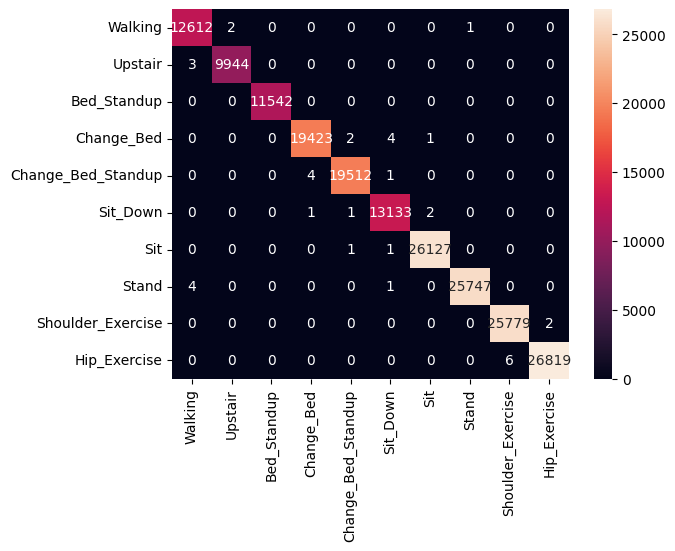

In [56]:
# missing_sensor_numbers = 2
# model_name = train_model_class[0].__name__
# print(model_name)

# all_test, all_pred = all_test_pred[missing_sensor_numbers][model_name]

# # print("missing index", missing_index)
# all_test_with_label = [label_list[i] for i in all_test]
# all_pred_with_label = [label_list[i] for i in all_pred]

# cf = confusion_matrix(all_test_with_label, all_pred_with_label, labels=label_list)
# sns.heatmap(cf, annot=True, xticklabels=eng_label_list, yticklabels=eng_label_list, fmt='g')

In [57]:
# from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# all_test_cpu = list(map(lambda x: x.cpu().item(), all_test))
# all_pred_cpu = list(map(lambda x: x.cpu().item(), all_pred))

# print("accuracy:", accuracy_score(all_test_cpu, all_pred_cpu))
# print("precision_score", precision_score(all_test_cpu, all_pred_cpu, average="macro"))
# print("recall_score", recall_score(all_test_cpu, all_pred_cpu, average="macro"))
# print("F1 score:", f1_score(all_test_cpu, all_pred_cpu, average="macro"))

accuracy: 0.9998059525370394
precision_score 0.9997788239621039
recall_score 0.9997967699899564
F1 score: 0.9997877907810004
